# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import setup_directories, train_dynamics
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    DynamicsConfig, NetworkConfig, lrConfig,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2020-08-26 18:34:24,645:INFO:Number of devices: 1


### Plot examples of (toy) target distributions:

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons_potential', 'sin_potential', 'sin_potential1', 'sin_potential2']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}')
plt.show()

## Define parameters of the model and target distribution:

In [2]:
import datetime

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE='two_moons_potential'
POTENTIAL_FN = two_moons_potential

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')
log_dir = os.path.join(BASE_DIR, MODEL_TYPE, date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)


flags = AttrDict({
    'restore': False,
    'horovod': False,
    'profiler': False,
    'xdim': 2,
    'eps': 0.2,
    'batch_size': 256,
    'num_steps': 10,
    'beta_init': 0.5,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 1000,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_value': 0.,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 250,
    'warmup_steps': 500,
    'print_steps': 100,
    'units': [100, 100],
    'hmc': False,
    'eps_trainable': True,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.25,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

## Train:

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [3]:
x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict(dict(flags))
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 1000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_trainable=flags.eps_trainable,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

2020-08-26 18:34:28,344:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426
2020-08-26 18:34:28,347:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training_hmc
2020-08-26 18:34:28,348:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training_hmc/train_data
2020-08-26 18:34:28,350:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training_hmc/checkpoints
2020-08-26 18:34:28,351:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training_hmc/summaries
2020-08-26 18:34:28,352:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training_hmc/dynamics_configs
2020-08-26 18:34:28,354:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training_hmc/FLAGS.z.

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/1000    0.03076      -7.045      0.9868       0.2         0.5          0      
   100/1000    0.02361      -1.188      0.985       0.2014       0.5          0      
   200/1000    0.02367      2.663       0.9853      0.2029       0.5          0      
   300/1000    0.02827      -2.006      0.9883      0.2042       0.5          0      
   400/1000    0.03147      -2.307      0.9836      0.2072       0.5          0      
   500/1000    0.03907      -3.534      0.9841      0.2182       0.5          0      
   600/1000     0.0453      -2.486      0.9867      0.203        0.5          0      
   700/1000    0.03292     -0.8777      0.9883      0.2053       0.5          0      
   800/1000    0.03609     -0.01675     0.9826      0.214

### Create `GenericDynamics` object

In [5]:
def identity(x):
    return x

config = DynamicsConfig(eps=flags.eps,
                        num_steps=flags.num_steps,
                        hmc=flags.hmc,
                        eps_trainable=flags.eps_trainable,
                        model_type=flags.model_type)
                        

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

dynamics = GenericDynamics(params=flags,
                           config=config,
                           lr_config=lr_config,
                           normalizer=identity,
                           network_config=net_config,
                           potential_fn=POTENTIAL_FN,
                           name=MODEL_TYPE)

2020-08-26 18:36:58,987:INFO:Number of devices: 1


### Train L2HMC sampler using HMC sampler as starting point

In [6]:
dirs = setup_directories(flags)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-08-26 18:37:04,340:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training
2020-08-26 18:37:04,342:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/train_data
2020-08-26 18:37:04,344:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/checkpoints
2020-08-26 18:37:04,345:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/summaries
2020-08-26 18:37:04,347:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/dynamics_configs
2020-08-26 18:37:04,350:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/FLAGS.z.
2020-08-26 18:37:07,297:INFO:**********************************************************************************************************************

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000   0.05836      -3.013      0.8969      0.2159       0.5      -0.003612  
   100/10000   0.06102      -2.207      0.8947      0.2131      0.5035     0.01181   
   200/10000   0.05825      -1.228      0.8311      0.209       0.507     -0.004752  
   300/10000   0.06777      -1.021      0.6498      0.2013      0.5105     0.002747  
   400/10000   0.05473     -0.3775      0.5827      0.2084      0.5141     0.01438   
   500/10000   0.06591     -0.9246      0.5943      0.1917      0.5176     0.01092   
   600/10000   0.06742      0.3169      0.5333      0.1929      0.5212    -0.007596  
   700/10000   0.07113     -0.3037      0.6369      0.175       0.5249    -0.006354  
   800/10000   0.07202      0.9018      0.5245      0.159

  9000/10000   0.07974      7.951       0.7014      0.1319      0.9331     -0.00566  
  9100/10000   0.08448      2.898       0.6917      0.1315      0.9396    -0.002132  
  9200/10000   0.06328      2.662       0.6479      0.1309      0.9461    0.0009085  
  9300/10000   0.07429      4.974       0.6131      0.1383      0.9527    -0.007011  
  9400/10000   0.07967      0.2493      0.6868      0.1406      0.9593     0.008942  
  9500/10000   0.08513      5.638       0.5487      0.1406      0.966      0.00369   
  9600/10000   0.07912      9.316       0.5624      0.1432      0.9727    0.0008008  
  9700/10000   0.08428      1.667       0.7372      0.1386      0.9795    -0.005082  
  9800/10000   0.07463      2.891       0.6233      0.145       0.9863    -0.003105  
  9900/10000   0.07088      3.887       0.7118      0.1312      0.9932     0.004907  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

## Run inference:

In [7]:
import utils.file_io as io

dirs = setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-08-26 18:51:39,112:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/FLAGS.z.
2020-08-26 18:51:39,115:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/training/checkpoints/ckpt-11


In [15]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final
flags.run_steps = 2000

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-08-26 18:55:33,269:INFO:Running inference with:
 beta: 1.0
eps: 0.1256
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.01329      74.49       0.7064      0.1256        1       -0.002259  
   100/5000    0.006455     2.389       0.7215      0.1256        1       -0.003382  
   200/5000    0.006496     1.751       0.7443      0.1256        1       -0.006503  
   300/5000    0.007017     2.385       0.7344      0.1256        1       0.0001164  
   400/5000    0.006531     0.2095      0.7284      0.1256        1        0.001227  
   500/5000    0.006945     6.321       0.7422      0.1256        1        0.005092  
   600/5000    0.006628     5.805       0.7453      0.1256        1        0.007398  
   700/5000    0.007404     14.26       0.7745      0.1256        1       -0.0002743 
   800/5000    0.006703     1.817       0.7585      0.1256        1       0.0004503  
   900/5000    0.006404     0.6859      0.7732      0.1256        1        0.004406  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

In [16]:
%matplotlib inline

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain0.png


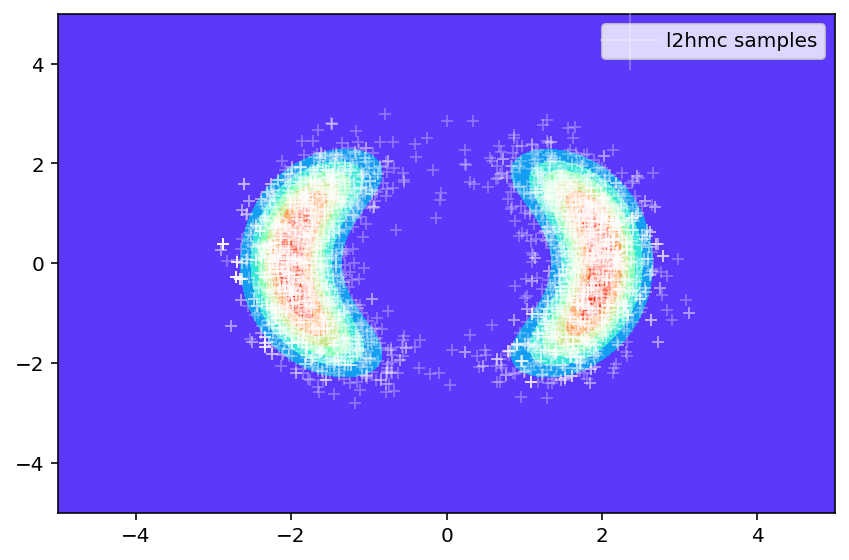

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain1.png


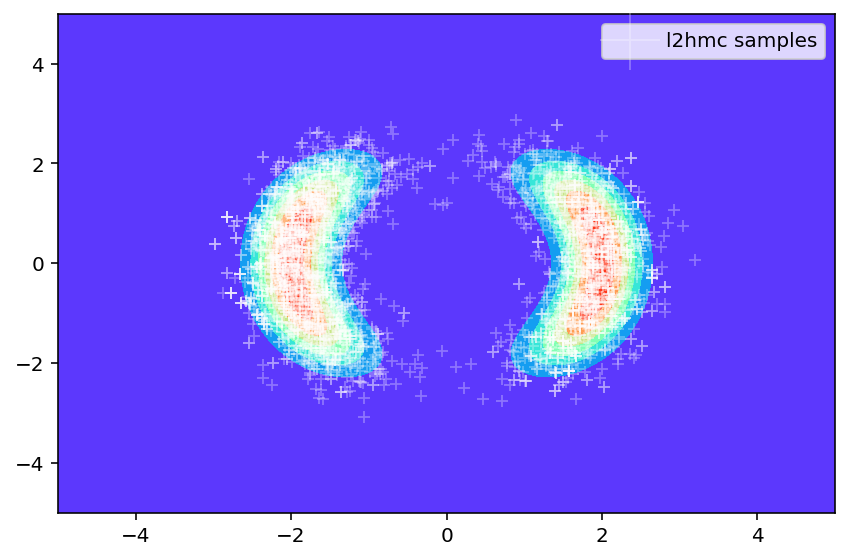

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain2.png


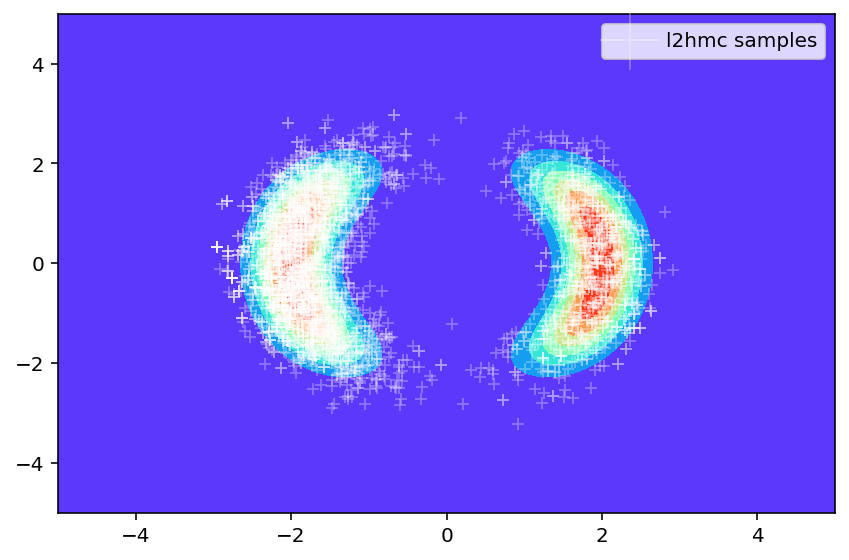

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain3.png


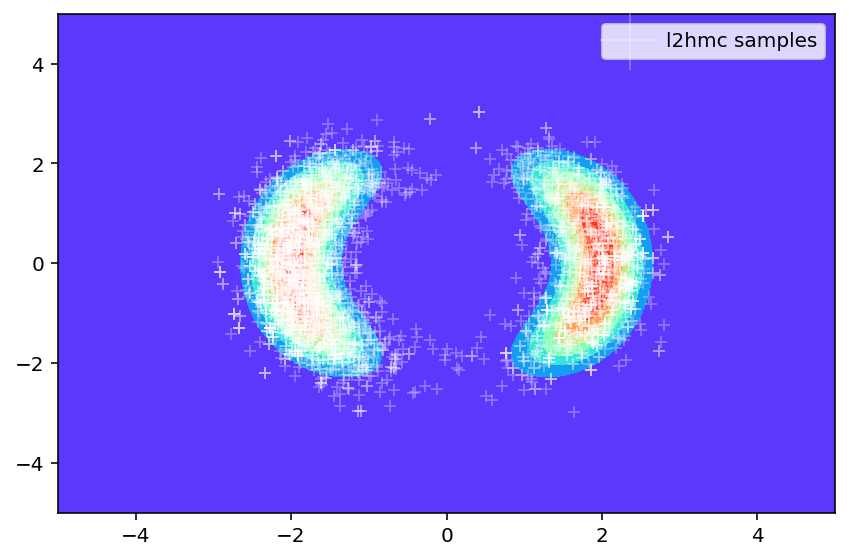

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain4.png


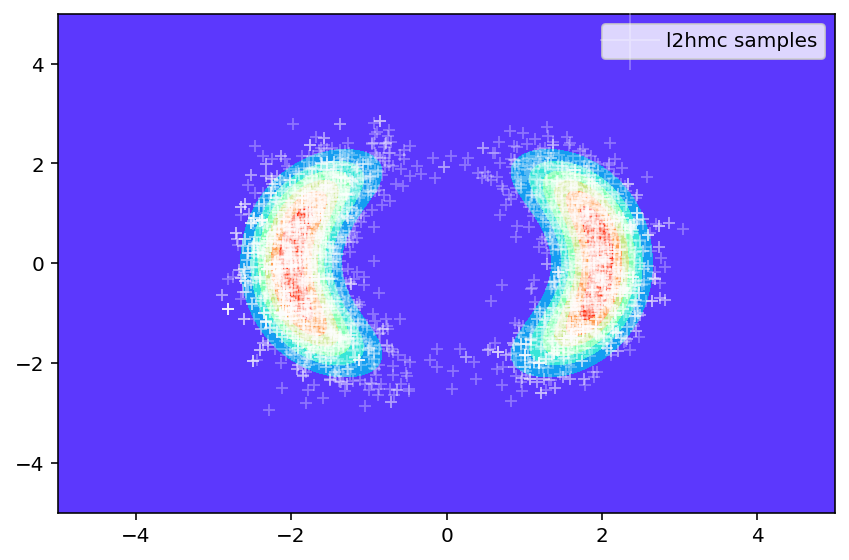

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain5.png


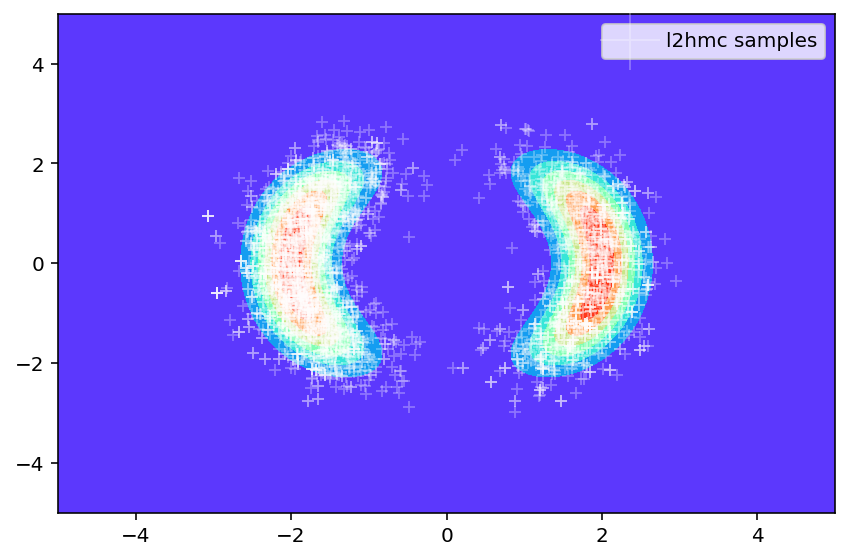

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain6.png


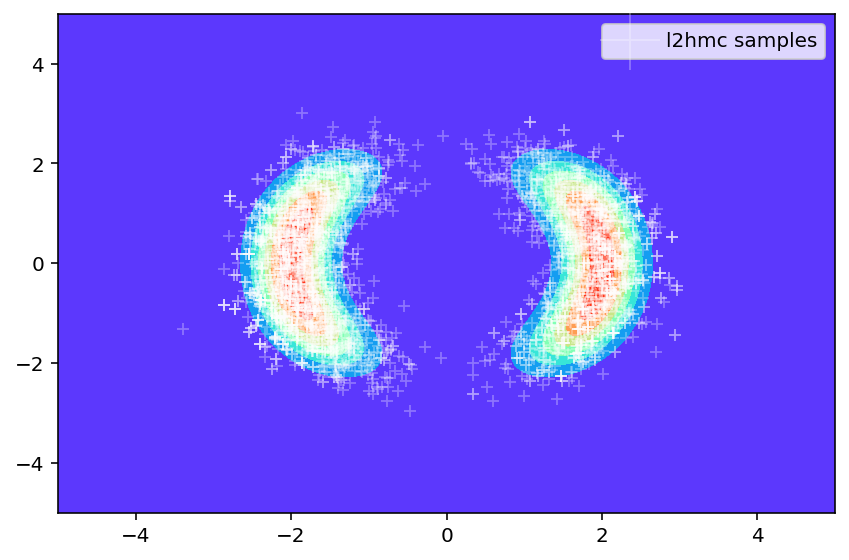

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain7.png


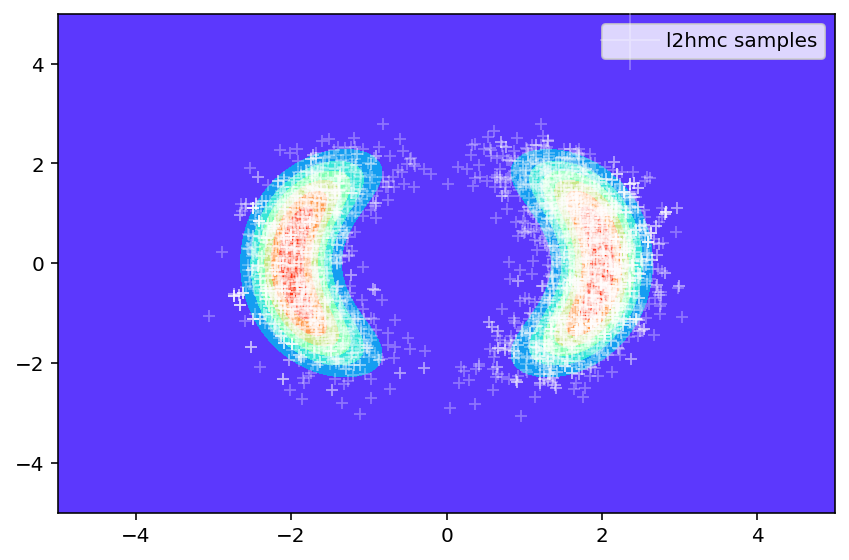

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain8.png


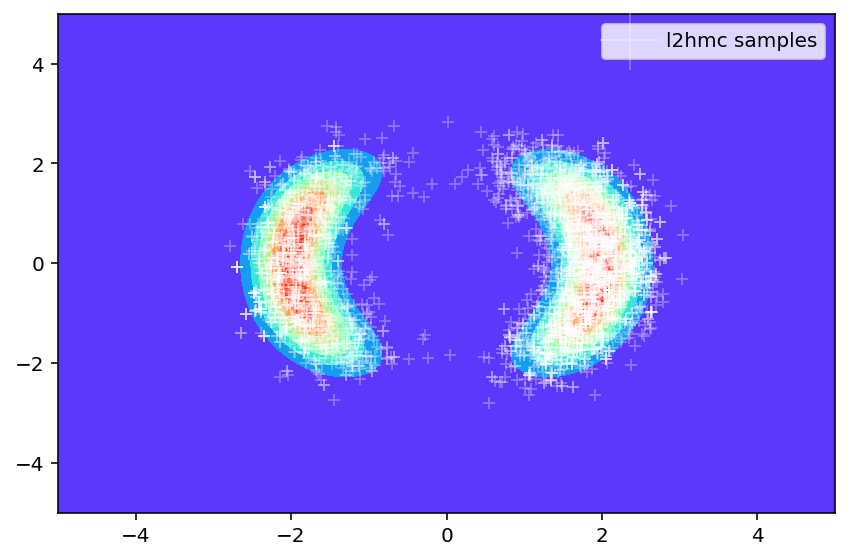

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain9.png


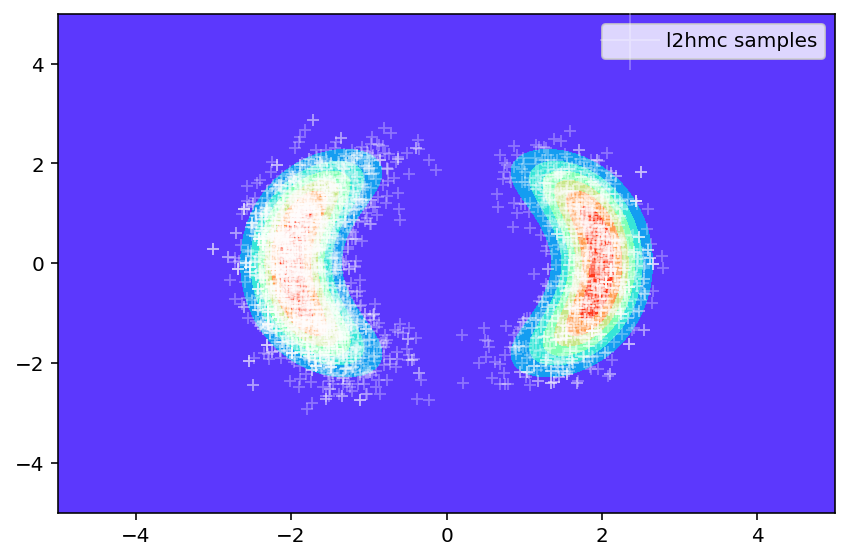

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain10.png


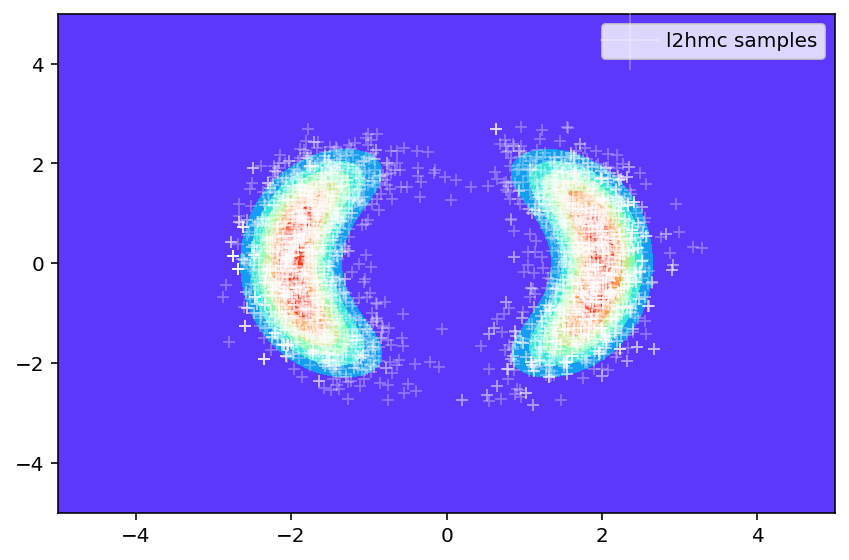

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-26/2020-08-26-183426/figures/trained_samples_chain11.png


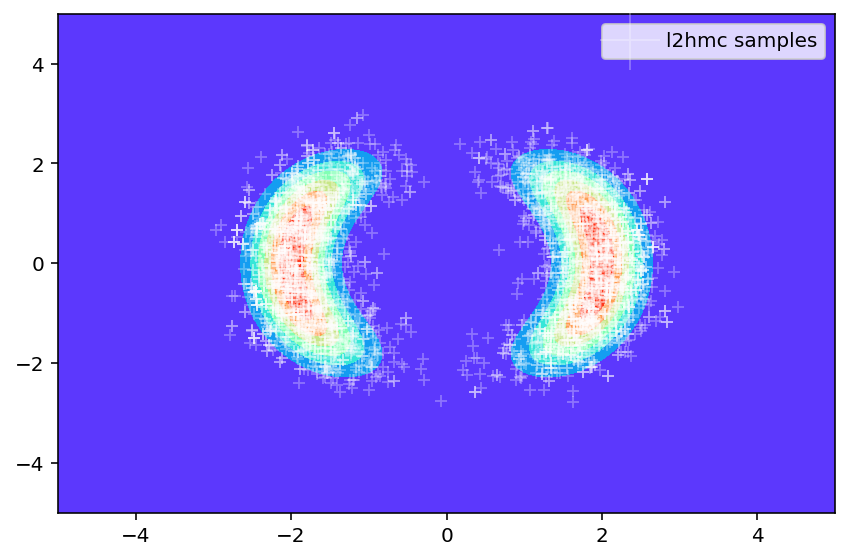

In [17]:
import utils.file_io as io
from utils.distributions import contour_potential

figs_dir = os.path.join(dirs.log_dir, 'figures')
io.check_else_make_dir(figs_dir)

x_arr = tf.convert_to_tensor(x_arr).numpy()

for chain in range(12):
    fig, ax = plt.subplots()
    xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
    #sns.kdeplot(*xy, ax=ax)
    #grid = xy.reshape(2, -1).T
    #Z = np.exp(-POTENTIAL_FN(grid))
    #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
    #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
    #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
    xlim = 5
    ylim = 5
    _ = contour_potential(POTENTIAL_FN, ax=ax, cmap='rainbow', xlim=xlim, ylim=ylim)
    _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                color='white', label='l2hmc samples')
    _ = ax.legend(markerscale=5., loc='best')
    _ = ax.set_xlim((-xlim, xlim))
    _ = ax.set_ylim((-ylim, ylim))
    out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
    print(f'Saving figure to: {out_file}')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()